# Initialize Environment

In [2]:
import matplotlib, matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
from scipy.stats import norm
from scipy.io import loadmat
import glob
import yfinance as yf
import pandas as pd
import datetime
from copy import deepcopy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Seed Random number generator for repeatability
np.random.seed(19690720)

plt.style.use('default')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams.update({'font.size': 18})

# Load Data

In [28]:
bonds   = ['EDV', 'BIV', 'VGIT', 'BLV', 'VGLT', 'VMBS', 'BSV', 'VTIP', 'VGSH', 'BND', 'VCIT', 'VCLT', 'VCSH', 'VTC', 'VTEB']
intl    = ['VT', 'VSGX', 'VEU', 'VSS', 'VEA', 'VGK', 'VPL', 'VNQI', 'VIGI', 'VYMI', 'VXUS', 'VWO']
sectors = ['VOX', 'VCR', 'VDC', 'VDE', 'VFH', 'VHT', 'VIS', 'VGT', 'VAW', 'VNQ', 'VPU']
tickers = sectors + bonds

data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = tickers,

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "2y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = False,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

print(data)
ddata = data.swaplevel(0,1,axis=1).drop(['Open', 'High', 'Low', 'Volume'], axis=1)
print(type(data), ddata)

[*********************100%***********************]  26 of 26 completed
                 VCSH                                                 VTIP  \
                 Open       High        Low      Close   Volume       Open   
Date                                                                         
2018-04-30  73.864711  73.893069  73.855257  73.883621  1747700  46.771969   
2018-05-01  73.881705  73.900645  73.805927  73.824875   760500  46.771968   
2018-05-02  73.843822  73.891185  73.824881  73.862770   999300  46.743252   
2018-05-03  73.938544  73.948018  73.900655  73.929077  1442100  46.781540   
2018-05-04  73.919601  73.938542  73.881713  73.919601   866000  46.810261   
...               ...        ...        ...        ...      ...        ...   
2020-04-22  80.650002  80.900002  80.550003  80.769997  2518500  49.230000   
2020-04-23  80.839996  80.870003  80.660004  80.830002  2377800  49.400002   
2020-04-24  80.879997  80.879997  80.739998  80.800003  2333000  49.310

# Plot Data

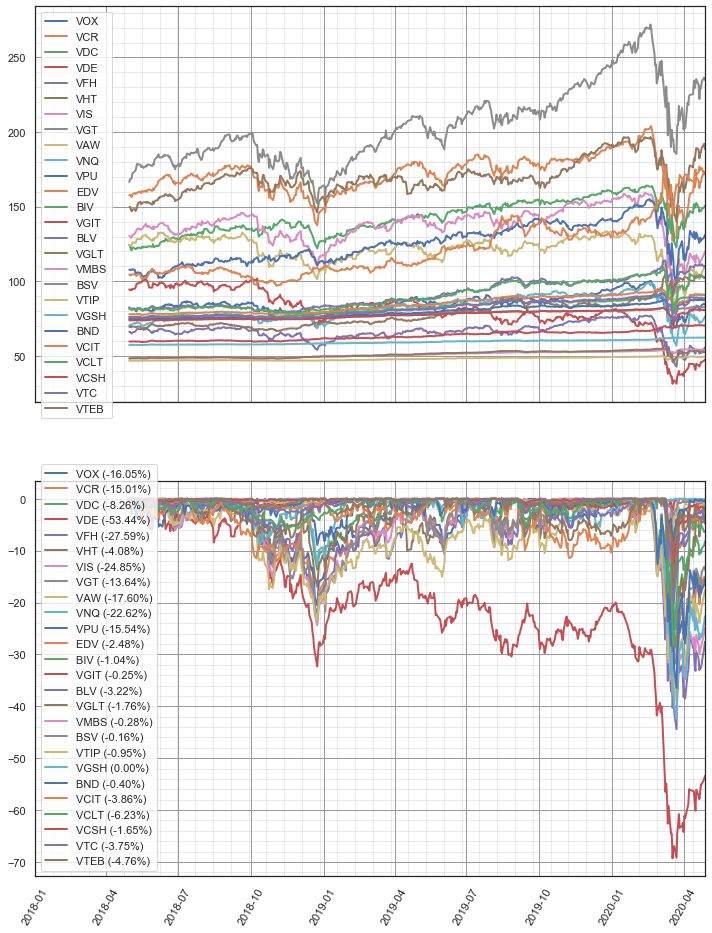

In [29]:
# Compute the drawdown of an array, in place.
def drawdown (array):
    dd=deepcopy(array)
    maxval=-1
    for i in range(len(dd)):
        idx = i
        if array[idx] > maxval: maxval = array[idx]
        dd[idx] = (array[idx]/maxval - 1.) * 100.
    return dd

close_prices = {}
# Plot the prices & drawdowns over/under
def plot_prices_dd(tickers, data, ax):
    for t in tickers:
        #print(t, data[t].columns)
        #print(t, data[t])
        close = data[t]['Close']
        close_prices[t] = close
        #print(type(close.index), type(close.values))
        dd = drawdown(close.values)

        ax[0].plot(close.index, close.values, label=t, linewidth=2.0)
        ax[0].grid(b=True, which='major', color='#999999', linestyle='-')
        ax[0].minorticks_on()
        ax[0].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        ax[0].legend(fancybox=True, loc=2)

        ax[1].plot(close.index, dd, label='{} ({:.2f}%)'.format(t,dd[-1]), linewidth=2.0)
        ax[1].grid(b=True, which='major', color='#999999', linestyle='-')
        ax[1].minorticks_on()
        ax[1].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        ax[1].legend(fancybox=True, loc=3)
        ax[1].set_xlim([datetime.date(2018, 1, 1), datetime.date.today()])
        plt.xticks(rotation=60)
    return



###########################################    
fig, ax  = plt.subplots(nrows=2, ncols=1,
                        sharex=True, sharey=False,
                        figsize=(12,8*2))

plot_prices_dd(tickers, data, ax)



#plt.show()
fig.savefig('shareprices.pdf', bbox_inches='tight')


# Correlations

In [30]:
corr = ddata.corr()

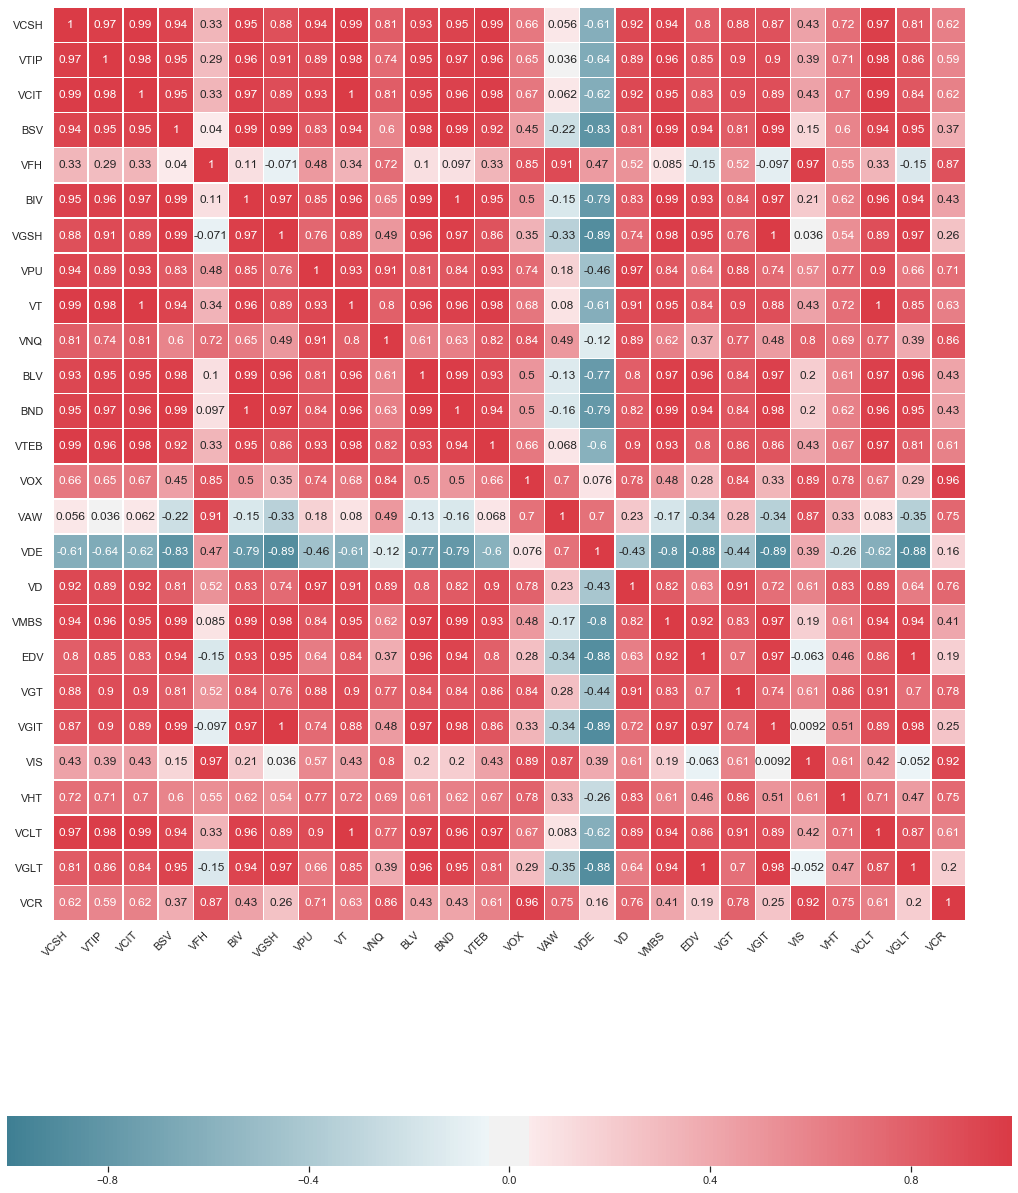

In [33]:
import seaborn as sns

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(24, 24))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=None, center=0, vmin=-1, vmax=1, cmap=cmap, annot=True,
            #xticklabels=False,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.75, "orientation": "horizontal"})
#            square=True, linewidths=.5, )

ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_yticklabels([ item.get_text().strip('Close-') for item in ax.get_yticklabels() ])
ax.set_xticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right')
(bottom, top) = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
f.savefig('correlation.pdf', bbox_inches='tight')

# Custom Heatmap

KeyError: 'index'

<Figure size 1000x1000 with 0 Axes>